# 1.0 Libraries & Set up

## In this section we import necessary libraries and apply plotting settings to the entire notebook

In [1]:
import os
os.chdir('../') # insures use of models folder as python module 
# Any figures saved or data pickled in the current working 
# directly will be saved up one folder from here.
import pybamm
import models
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] =  18.0

In [2]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T_30 = 303.15
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.2C rate
I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# New exchange current constants
ih0 = 5
im0 = 5
il0 = 5

# Saturation mass constant
S_star_30 = 1e-6

# dissolution rate
kd_30 = 5000

# shuttle rate
ks_30 = 1e-5

# Initial value of Precipitated sulfur at start of charge
Sp_initial_cha_30 = .43

# Initial value of S1 anion at start of charge
S1_initial_cha_30 = 1e-3

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T_30))*(V_initial_cha - (2*R*T_30/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T_30))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T_30))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha_30 = S2_func(S1_initial_cha_30)

# Initial charge value of S2
S4_initial_cha_30 = S4_func(S2_initial_cha_30)

# Initial charge value of S2
S8_initial_cha_30 = S8_func(S4_initial_cha_30)

# Initial high plateau potential 
EH_30 = EH0 + (R*T_30)*np.log(f_h*(S8_initial_cha_30**(1/4))/(S4_initial_cha_30**(1/2)))/(F)

# Initial high plateau over-potential
eta_H_30 = V_initial_cha - EH_30

# Initial high plateau current
iH_30 = -2*ih0*ar*np.sinh(F*eta_H_30/(2*R*T_30))

# Initial middle plateau potential
EM_30 = EM0 + (R*T_30)*np.log(f_m*(S4_initial_cha_30**(1/2))/S2_initial_cha_30)/(F)

# Initial middle plateau over-potentia
eta_M_30 = V_initial_cha - EM_30

# Initial middle plateau current
iM_30 = -2*im0*ar*np.sinh(F*eta_M_30/(2*R*T_30))

# Initial low plateau potential
EL_30 = EL0 + (R*T_30/F)*np.log(f_l*(S2_initial_cha_30**(1/2))/S1_initial_cha_30)

# Initial low plateau over-potentia
eta_L_30 = V_initial_cha - EL_30

# Initial low plateau current
iL_30 = -2*il0*ar*np.sinh(F*eta_L_30/(2*R*T_30))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha_30))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha_30))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha_30))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha_30))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha_30))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH_30))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H_30))
print('The initial charge value of the high plateau current is {} A'.format(iH_30))
print('The initial charge value of the middle plateau potential is {} V'.format(EM_30))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M_30))
print('The initial charge value of the middle plateau current is {} A'.format(iM_30))
print('The initial charge value of the low plateau potential is {} V'.format(EL_30))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L_30))
print('The initial charge value of the low plateau current is {} A'.format(iL_30))

The initial charge value of precipitated sulfur is 0.43 g
The initial charge value of S1 anion is 0.001 g
The initial charge value of S2 anion is 0.011487966377185257 g
The initial charge value of S4 anion is 8.425161409668764e-18 g
The initial charge value of S8 anion is 2.467917664668259e-63 g
The initial charge value of voltage is 2.0 V
The initial charge value of the high plateau potential is 2.0 V
The initial charge value of the high plateau over-potential is 0.0 V
The initial charge value of the high plateau current is -0.0 A
The initial charge value of the middle plateau potential is 2.0 V
The initial charge value of the middle plateau over-potential is 0.0 V
The initial charge value of the middle plateau current is -0.0 A
The initial charge value of the low plateau potential is 1.999885170817739 V
The initial charge value of the low plateau over-potential is 0.00011482918226102257 V
The initial charge value of the low plateau current is -0.02110000000001298 A


In [3]:
model = pybamm.BaseModel()

V = pybamm.Variable("Terminal voltage [V]")


# set internal variables
S8 = pybamm.Variable("S8 [g]")
S4 = pybamm.Variable("S4 [g]")
S2 = pybamm.Variable("S2 [g]")
S = pybamm.Variable("S [g]")
Sp = pybamm.Variable("Precipitated Sulfur [g]")

#######################################
# Model parameters
#######################################

#from models.parameters.cornish2021_parameters import Cornish2021Parameters
#model.param = Cornish2021Parameters()
#param = model.param
'''
I = -0.0211
# standard parameters
R = param.R
F = param.F
T = param.T_ref

# parameters
Ms = param.Ms
ns = param.ns
ns2 = param.ns2
ns4 = param.ns4
ns8 = param.ns8
ne = param.ne
ih0 = param.ih0
im0 = param.im0
il0 = param.il0
rho_s = param.rho_s
EH0 = param.EH0
EM0 = param.EM0
EL0 = param.EL0
v = param.v
ar = param.ar
k_p = param.k_p
k_d = param.k_d
S_star = param.S_star
k_s_charge = param.k_s_charge
k_s_discharge = param.k_s_discharge
'''
rho_s = 0.9#param.rho_s
v = nu
Ms = 32#param.Ms
ns = 1#param.ns
ns2 = 2#param.ns2
ns4 = 4#param.ns4
ns8 = 8#param.ns8
ne = 1#param.ne
T = T_30
k_s_charge = 0.001
k_s_discharge = 0
k_p = kd_30
k_d = kd_30
S_star = S_star_30
# parameters derived from other parameters
nH = 1
nM = 1
nL = 1
iH_coef = nH * F / (2 * R * T)
iM_coef = nM * F / (2 * R * T)
iL_coef = nL * F / (2 * R * T)
E_H_coef = R * T / (nH * F)
E_M_coef = R * T / (nM * F)
E_L_coef = R * T / (nL * F)
f_h = ((ns4 ** 2) * Ms * v / ns8)**(1/4)
f_m = ((ns2 ** 2) * Ms * v / ns4)**(1/2)
f_l = ((ns ** 2) * Ms * v / ns2)**(1/2)

#######################################################
# Non-dynamic model functions
#######################################################

# High plateau potenital [V] as defined by equation (2a) in [1]
E_H = EH0 + E_H_coef * (pybamm.log(f_h) + 0.25*pybamm.log(S8) - 0.5*pybamm.log(S4) )

E_M = EM0 + E_M_coef * (pybamm.log(f_m) + 0.5*pybamm.log(S4) - pybamm.log(S2) ) 

# Low plateau potenital [V] as defined by equation (2b) in [1]
E_L = EL0 + E_L_coef * (pybamm.log(f_l) + 0.5*pybamm.log(S2) - pybamm.log(S) ) 

# High plateau over-potenital [V] as defined by equation (6a) in [1]
eta_H = V - E_H

eta_M = V - E_M

# Low plateau over-potenital [V] as defined by equation (6b) in [1]
eta_L = V - E_L

# High plateau current [A] as defined by equation (5a) in [1]
i_H = -2 * ih0 * ar * pybamm.sinh(iH_coef * eta_H)

i_M = -2 * im0 * ar * pybamm.sinh(iM_coef * eta_M)

# Low plateau current [A] as defined by equation (5b) in [1]
i_L = -2 * il0 * ar * pybamm.sinh(iL_coef * eta_L)

# Theoretical capacity [Ah] of the cell as defined by equation (2) in [2]
cth = (3 * ne * F * S8 / (ns8 * Ms) + ne * F * S4 / (ns4 * Ms)) / 3600

# Shuttle coefficient
k_s = ( k_s_charge * (I < 0) ) + ( k_s_discharge * (I >= 0) )

# Precipitation/Dissolution rate
k_pd = ( k_d * (I < 0) ) + ( k_p * (I >= 0) )

###################################
# Dynamic model functions
###################################


# Differential equation (8a) in [1]
dS8dt = -(ns8 * Ms * i_H / (nH * F)) - k_s * S8

# Differential equation (8b) in [1]
dS4dt = (ns8 * Ms * i_H / (nH * F)) + k_s * S8 - (ns4 * Ms * i_M / (nM * F))

# Differential equation (8c) in [1]
dS2dt = ns4 * Ms * i_M / (nM * F) - (ns2 * Ms * i_L / (nM * F)) 

# Differential equation (8d) in [1]
dSdt = (ns2 * Ms * i_L / (nM * F)) - k_p * Sp * (S - S_star) / (v * rho_s)

# Differential equation (8e) in [1]
dSpdt = k_pd * Sp * (S - S_star) / (v * rho_s)



numerator_H = -ih0*pybamm.cosh(iH_coef * eta_H)*( (dS8dt/S8) - 2*(dS4dt/S4) )
numerator_M = -im0*pybamm.cosh(iM_coef * eta_M)*( (dS4dt/S4) - 2*(dS2dt/S2) )
numerator_L = -il0*pybamm.cosh(iL_coef * eta_L)*( (dS2dt/S2) - 2*(dSdt/S) )

denominator_H = nH*ih0*pybamm.cosh(iH_coef * eta_H)
denominator_M = nM*im0*pybamm.cosh(iM_coef * eta_M)
denominator_L = nL*il0*pybamm.cosh(iL_coef * eta_L)

dVdt = ( numerator_H + numerator_M + numerator_L )/(denominator_H + denominator_M + denominator_L)

model.rhs = {S8: dS8dt, S4: dS4dt, S2: dS2dt, S: dSdt, Sp: dSpdt,V:dVdt}

##############################
# Model variables
#############################

model.variables.update(
    {
        #"Time [s]": pybamm.t * model.timescale,
        #"Capacity [Ah]": pybamm.t * model.timescale * pybamm.AbsoluteValue(I) / 3600,
        "S8 [g]": S8,
        "S4 [g]": S4,
        "S2 [g]": S2,
        "S [g]": S,
        "Precipitated Sulfur [g]": Sp,
        "Terminal voltage [V]": V,
        "Shuttle coefficient [s-1]": k_s,
        "Shuttle rate [g-1.s-1]": k_s * S8,
        "High plateau potential [V]": E_H,
        "Low plateau potential [V]": E_L,
        "High plateau over-potential [V]": eta_H,
        "Middle plateau over-potential [V]": eta_M,
        "Low plateau over-potential [V]": eta_L,
        "High plateau current [A]": i_H,
        "Middle plateau current [A]": i_M,
        "Low plateau current [A]": i_L,
        "Theoretical capacity [Ah]": cth,
    }
)

In [4]:
model.initial_conditions.update(
    {
        model.variables["S8 [g]"]: S8_initial_cha_30,
        model.variables["S4 [g]"]: S4_initial_cha_30,
        model.variables["S2 [g]"]: S2_initial_cha_30,
        model.variables["S [g]"]: S1_initial_cha_30,
        model.variables["Precipitated Sulfur [g]"]: Sp_initial_cha_30,
        model.variables['Terminal voltage [V]']: 2.0
    }
)
# Instantiate the model
model_30 = model

# Obtain model parameter dictionary
#param_30 = model_30.parameters
#disc = pybamm.Discretisation()
#disc.process_model(model_30);
# Update the parameters for charge
'''
param_30.update(
    {
        #"Current [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha_30,
        "Initial Condition for S4 ion [g]" : S4_initial_cha_30,
        "Initial Condition for S2 ion [g]" : S2_initial_cha_30,
        "Initial Condition for S ion [g]" : S1_initial_cha_30,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha_30,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Shuttle rate coefficient during charge [s-1]': ks_30,
        'Dissolution rate [s-1]': kd_30,
        'Reference Temperature [K]': T_30
        }
)
'''
ode_solver = pybamm.ScipySolver()

#disc = pybamm.Discretisation()
#disc.process_model(model_30);

t_eval = np.linspace(0, 5, 30)
solution = ode_solver.solve(model, t_eval)

AttributeError: 'numpy.float64' object has no attribute 'id'

In [9]:
model = pybamm.BaseModel()

V = pybamm.Variable("Terminal voltage [V]")


# set internal variables
S8 = pybamm.Variable("S8 [g]")
S4 = pybamm.Variable("S4 [g]")
S2 = pybamm.Variable("S2 [g]")
S = pybamm.Variable("S [g]")
Sp = pybamm.Variable("Precipitated Sulfur [g]")

#######################################
# Model parameters
#######################################
from models.parameters.cornish2021_parameters import Cornish2021Parameters
model.param = Cornish2021Parameters()
param = model.param
I = -0.0211
# standard parameters
R = param.R
F = param.F
T = param.T_ref

# parameters
Ms = param.Ms
ns = param.ns
ns2 = param.ns2
ns4 = param.ns4
ns8 = param.ns8
ne = param.ne
ih0 = param.ih0
im0 = param.im0
il0 = param.il0
rho_s = param.rho_s
EH0 = param.EH0
EM0 = param.EM0
EL0 = param.EL0
v = param.v
ar = param.ar
k_p = param.k_p
k_d = param.k_d
S_star = param.S_star
k_s_charge = param.k_s_charge
k_s_discharge = param.k_s_discharge


# parameters derived from other parameters
nH = 1
nM = 1
nL = 1
iH_coef = nH * F / (2 * R * T)
iM_coef = nM * F / (2 * R * T)
iL_coef = nL * F / (2 * R * T)
E_H_coef = R * T / (nH * F)
E_M_coef = R * T / (nM * F)
E_L_coef = R * T / (nL * F)
f_h = ((ns4 ** 2) * Ms * v / ns8)**(1/4)
f_m = ((ns2 ** 2) * Ms * v / ns4)**(1/2)
f_l = ((ns ** 2) * Ms * v / ns2)**(1/2)

#######################################################
# Non-dynamic model functions
#######################################################

# High plateau potenital [V] as defined by equation (2a) in [1]
E_H = EH0 + E_H_coef * (pybamm.log(f_h) + 0.25*pybamm.log(S8) - 0.5*pybamm.log(S4) )

E_M = EM0 + E_M_coef * (pybamm.log(f_m) + 0.5*pybamm.log(S4) - pybamm.log(S2) ) 

# Low plateau potenital [V] as defined by equation (2b) in [1]
E_L = EL0 + E_L_coef * (pybamm.log(f_l) + 0.5*pybamm.log(S2) - pybamm.log(S) ) 

# High plateau over-potenital [V] as defined by equation (6a) in [1]
eta_H = V - E_H

eta_M = V - E_M

# Low plateau over-potenital [V] as defined by equation (6b) in [1]
eta_L = V - E_L

# High plateau current [A] as defined by equation (5a) in [1]
i_H = -2 * ih0 * ar * pybamm.sinh(iH_coef * eta_H)

i_M = -2 * im0 * ar * pybamm.sinh(iM_coef * eta_M)

# Low plateau current [A] as defined by equation (5b) in [1]
i_L = -2 * il0 * ar * pybamm.sinh(iL_coef * eta_L)

# Theoretical capacity [Ah] of the cell as defined by equation (2) in [2]
cth = (3 * ne * F * S8 / (ns8 * Ms) + ne * F * S4 / (ns4 * Ms)) / 3600

# Shuttle coefficient
k_s = ( k_s_charge * (I < 0) ) + ( k_s_discharge * (I >= 0) )

# Precipitation/Dissolution rate
k_pd = ( k_d * (I < 0) ) + ( k_p * (I >= 0) )

###################################
# Dynamic model functions
###################################


# Differential equation (8a) in [1]
dS8dt = -(ns8 * Ms * i_H / (nH * F)) - k_s * S8

# Differential equation (8b) in [1]
dS4dt = (ns8 * Ms * i_H / (nH * F)) + k_s * S8 - (ns4 * Ms * i_M / (nM * F))

# Differential equation (8c) in [1]
dS2dt = ns4 * Ms * i_M / (nM * F) - (ns2 * Ms * i_L / (nM * F)) 

# Differential equation (8d) in [1]
dSdt = (ns2 * Ms * i_L / (nM * F)) - k_p * Sp * (S - S_star) / (v * rho_s)

# Differential equation (8e) in [1]
dSpdt = k_pd * Sp * (S - S_star) / (v * rho_s)

model.rhs = {S8: dS8dt, S4: dS4dt, S2: dS2dt, S: dSdt, Sp: dSpdt}

numerator_H = -ih0*pybamm.cosh(iH_coef * eta_H)*( (dS8dt/S8) - 2*(dS4dt/S4) )
numerator_M = -im0*pybamm.cosh(iM_coef * eta_M)*( (dS4dt/S4) - 2*(dS2dt/S2) )
numerator_L = -il0*pybamm.cosh(iL_coef * eta_L)*( (dS2dt/S2) - 2*(dSdt/S) )

denominator_H = nH*ih0*pybamm.cosh(iH_coef * eta_H)
denominator_M = nM*im0*pybamm.cosh(iM_coef * eta_M)
denominator_L = nL*il0*pybamm.cosh(iL_coef * eta_L)

dVdt = ( numerator_H + numerator_M + numerator_L )/(denominator_H + denominator_M + denominator_L)
model.rhs.update({V:dVdt})

##############################
# Model variables
#############################

model.variables.update(
    {
        "Time [s]": pybamm.t * model.timescale,
        "Capacity [Ah]": pybamm.t * model.timescale * pybamm.AbsoluteValue(I) / 3600,
        "S8 [g]": S8,
        "S4 [g]": S4,
        "S2 [g]": S2,
        "S [g]": S,
        "Precipitated Sulfur [g]": Sp,
        "Terminal voltage [V]": V,
        "Shuttle coefficient [s-1]": k_s,
        "Shuttle rate [g-1.s-1]": k_s * S8,
        "High plateau potential [V]": E_H,
        "Low plateau potential [V]": E_L,
        "High plateau over-potential [V]": eta_H,
        "Middle plateau over-potential [V]": eta_M,
        "Low plateau over-potential [V]": eta_L,
        "High plateau current [A]": i_H,
        "Middle plateau current [A]": i_M,
        "Low plateau current [A]": i_L,
        "Theoretical capacity [Ah]": cth,
    }
)

######################################
# Discharge initial condition
# The values are found by considering the zero-current
# state of the battery. Set S8, S4, and Sp as written
# below. Then, solve eta_H = V, eta_L = V, the algebraic
# condition, and mass conservation for the remaining values.
######################################





# 1.1 Single Layer Cell held at 30 degrees C

## 1.1.1 Initial conditions and basic parameters

### Parameter values and initial values as discussed in Cornish & Marinescu (2021) regarding equations (8), (9a), and (9b).

In [10]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T_30 = 303.15
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.2C rate
#I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# New exchange current constants
ih0 = 5
im0 = 5
il0 = 5

# Saturation mass constant
S_star_30 = 1e-6

# dissolution rate
kd_30 = 5000

# shuttle rate
ks_30 = 1e-5

# Initial value of Precipitated sulfur at start of charge
Sp_initial_cha_30 = .43

# Initial value of S1 anion at start of charge
S1_initial_cha_30 = 1e-3

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T_30))*(V_initial_cha - (2*R*T_30/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T_30))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T_30))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha_30 = S2_func(S1_initial_cha_30)

# Initial charge value of S2
S4_initial_cha_30 = S4_func(S2_initial_cha_30)

# Initial charge value of S2
S8_initial_cha_30 = S8_func(S4_initial_cha_30)

# Initial high plateau potential 
EH_30 = EH0 + (R*T_30)*np.log(f_h*(S8_initial_cha_30**(1/4))/(S4_initial_cha_30**(1/2)))/(F)

# Initial high plateau over-potential
eta_H_30 = V_initial_cha - EH_30

# Initial high plateau current
iH_30 = -2*ih0*ar*np.sinh(F*eta_H_30/(2*R*T_30))

# Initial middle plateau potential
EM_30 = EM0 + (R*T_30)*np.log(f_m*(S4_initial_cha_30**(1/2))/S2_initial_cha_30)/(F)

# Initial middle plateau over-potentia
eta_M_30 = V_initial_cha - EM_30

# Initial middle plateau current
iM_30 = -2*im0*ar*np.sinh(F*eta_M_30/(2*R*T_30))

# Initial low plateau potential
EL_30 = EL0 + (R*T_30/F)*np.log(f_l*(S2_initial_cha_30**(1/2))/S1_initial_cha_30)

# Initial low plateau over-potentia
eta_L_30 = V_initial_cha - EL_30

# Initial low plateau current
iL_30 = -2*il0*ar*np.sinh(F*eta_L_30/(2*R*T_30))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha_30))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha_30))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha_30))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha_30))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha_30))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH_30))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H_30))
print('The initial charge value of the high plateau current is {} A'.format(iH_30))
print('The initial charge value of the middle plateau potential is {} V'.format(EM_30))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M_30))
print('The initial charge value of the middle plateau current is {} A'.format(iM_30))
print('The initial charge value of the low plateau potential is {} V'.format(EL_30))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L_30))
print('The initial charge value of the low plateau current is {} A'.format(iL_30))

The initial charge value of precipitated sulfur is 0.43 g
The initial charge value of S1 anion is 0.001 g
The initial charge value of S2 anion is 0.011487966377185257 g
The initial charge value of S4 anion is 8.425161409668764e-18 g
The initial charge value of S8 anion is 2.467917664668259e-63 g
The initial charge value of voltage is 2.0 V
The initial charge value of the high plateau potential is 2.0 V
The initial charge value of the high plateau over-potential is 0.0 V
The initial charge value of the high plateau current is -0.0 A
The initial charge value of the middle plateau potential is 2.0 V
The initial charge value of the middle plateau over-potential is 0.0 V
The initial charge value of the middle plateau current is -0.0 A
The initial charge value of the low plateau potential is 1.999885170817739 V
The initial charge value of the low plateau over-potential is 0.00011482918226102257 V
The initial charge value of the low plateau current is -0.02110000000001298 A


In [11]:

model.initial_conditions.update(
    {
        model.variables["S8 [g]"]: S8_initial_cha_30,
        model.variables["S4 [g]"]: S4_initial_cha_30,
        model.variables["S2 [g]"]: S2_initial_cha_30,
        model.variables["S [g]"]: S1_initial_cha_30,
        model.variables["Precipitated Sulfur [g]"]: Sp_initial_cha_30,
        model.variables['Terminal voltage [V]']: 2.0
    }
)
# Instantiate the model
model_30 = model

# Obtain model parameter dictionary
#param_30 = model_30.parameters
#disc = pybamm.Discretisation()
#disc.process_model(model_30);
# Update the parameters for charge
'''
param_30.update(
    {
        #"Current [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha_30,
        "Initial Condition for S4 ion [g]" : S4_initial_cha_30,
        "Initial Condition for S2 ion [g]" : S2_initial_cha_30,
        "Initial Condition for S ion [g]" : S1_initial_cha_30,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha_30,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Shuttle rate coefficient during charge [s-1]': ks_30,
        'Dissolution rate [s-1]': kd_30,
        'Reference Temperature [K]': T_30
        }
)
'''
ode_solver = pybamm.ScipySolver()

#disc = pybamm.Discretisation()
#disc.process_model(model_30);

t_eval = np.linspace(0, 5, 30)
solution = ode_solver.solve(model, t_eval)

AttributeError: 'numpy.float64' object has no attribute 'id'

In [7]:
model.input_parameters

AttributeError: 'numpy.float64' object has no attribute 'id'

## 1.1.2 Fit 30 Degree Cell Charge Voltage 

In [10]:
# Instantiate the model
model_30 = models.Cornish2021_ODE()


# Obtain model parameter dictionary
param_30 = model_30.default_parameter_values

# Update the parameters for charge
param_30.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha_30,
        "Initial Condition for S4 ion [g]" : S4_initial_cha_30,
        "Initial Condition for S2 ion [g]" : S2_initial_cha_30,
        "Initial Condition for S ion [g]" : S1_initial_cha_30,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha_30,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Shuttle rate coefficient during charge [s-1]': ks_30,
        'Dissolution rate [s-1]': kd_30,
        'Reference Temperature [K]': T_30
        }
)

ode_solver = pybamm.ScipySolver()

disc = pybamm.Discretisation()
disc.process_model(model_30);

t_eval = np.linspace(0, 5, 30)
solution = ode_solver.solve(model_30, t_eval)
'''
# Instantiate simulation object 
sim_30_cha1 = pybamm.Simulation(
    model_30,
    parameter_values = param_30,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Define the time cut-off for charging in second
time_in_seconds = 1.2*int(3600/0.1)

# Simulate the model 
#sim_30_cha1.solve([0,time_in_seconds]);


sim_30_cha1 = run_simulation(sim_30_cha1)
'''

NotImplementedError: method self.evaluate() not implemented
               for symbol Initial Condition for S8 ion [g] of type <class 'pybamm.expression_tree.parameter.Parameter'>

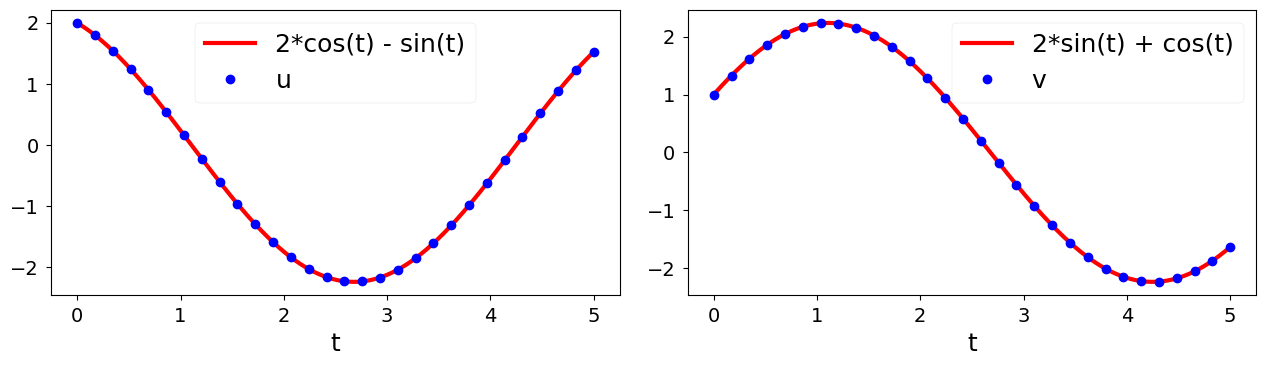

In [11]:
# Create model
model = pybamm.BaseModel()
u = pybamm.Variable("u")
v = pybamm.Variable("v")
model.rhs = {u: -v, v: u}
model.initial_conditions = {u: 2, v: 1}
model.variables = {"u": u, "v": v}

# Discretise using default discretisation
disc = pybamm.Discretisation()
disc.process_model(model);

# Solve ########################
t_eval = np.linspace(0, 5, 30)
solution = ode_solver.solve(model, t_eval)
################################

# Extract u and v
t_sol = solution.t
u = solution["u"]
v = solution["v"]

# Plot
t_fine = np.linspace(0,t_eval[-1],1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_fine, 2 * np.cos(t_fine) - np.sin(t_fine), t_sol, u(t_sol), "o")
ax1.set_xlabel("t")
ax1.legend(["2*cos(t) - sin(t)", "u"], loc="best")

ax2.plot(t_fine, 2 * np.sin(t_fine) + np.cos(t_fine), t_sol, v(t_sol), "o")
ax2.set_xlabel("t")
ax2.legend(["2*sin(t) + cos(t)", "v"], loc="best")

plt.tight_layout()
plt.show()

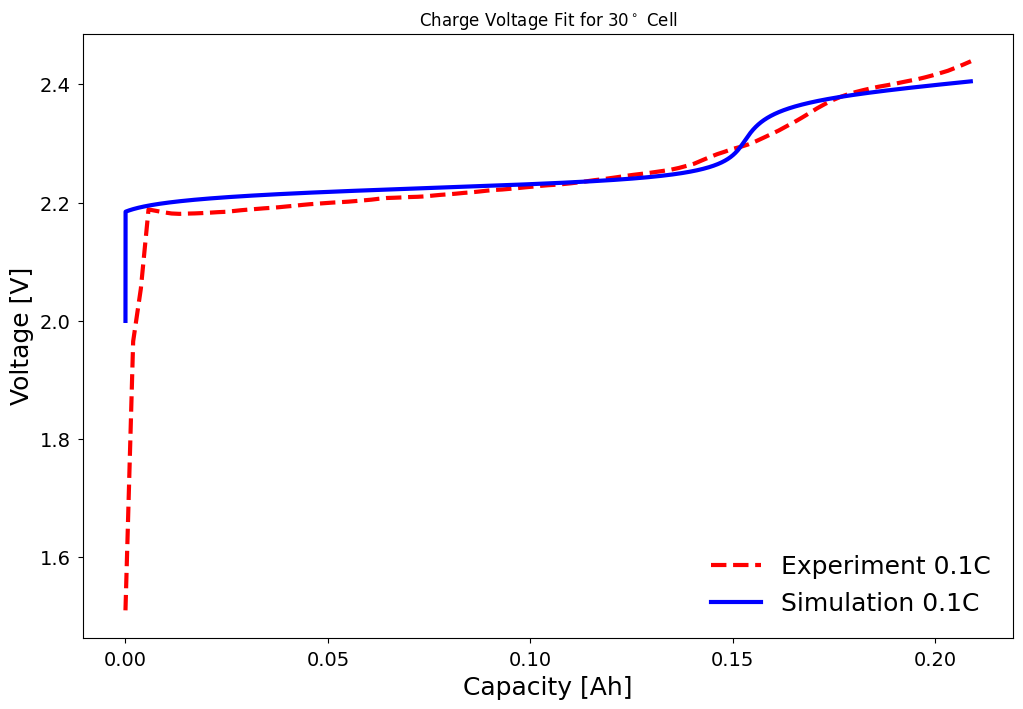

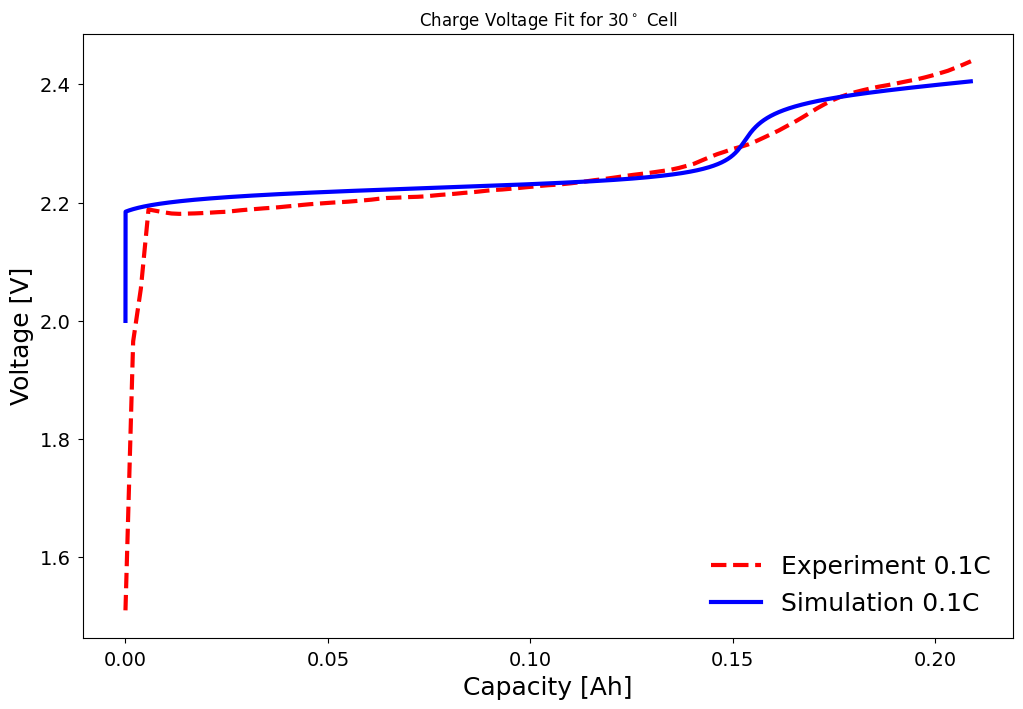

In [5]:
# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'], linestyle='--')

index_30 = len(sim_30_cha1.solution.t[sim_30_cha1.solution.t*0.0211/3600 < charge_data['30']['capacity'][-1]])

capacity = abs(I)*sim_30_cha1.solution.t[:index_30]/3600
voltage = sim_30_cha1.solution['Terminal voltage [V]'].entries[:index_30]


plt.plot(capacity, voltage)
plt.title("Charge Voltage Fit for $30^\circ$ Cell")
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

## 1.1.3 Fit the Charge Resistance

0.03156707739133703
0.24857043217435532
0.03156707739133703
0.24857043217435532


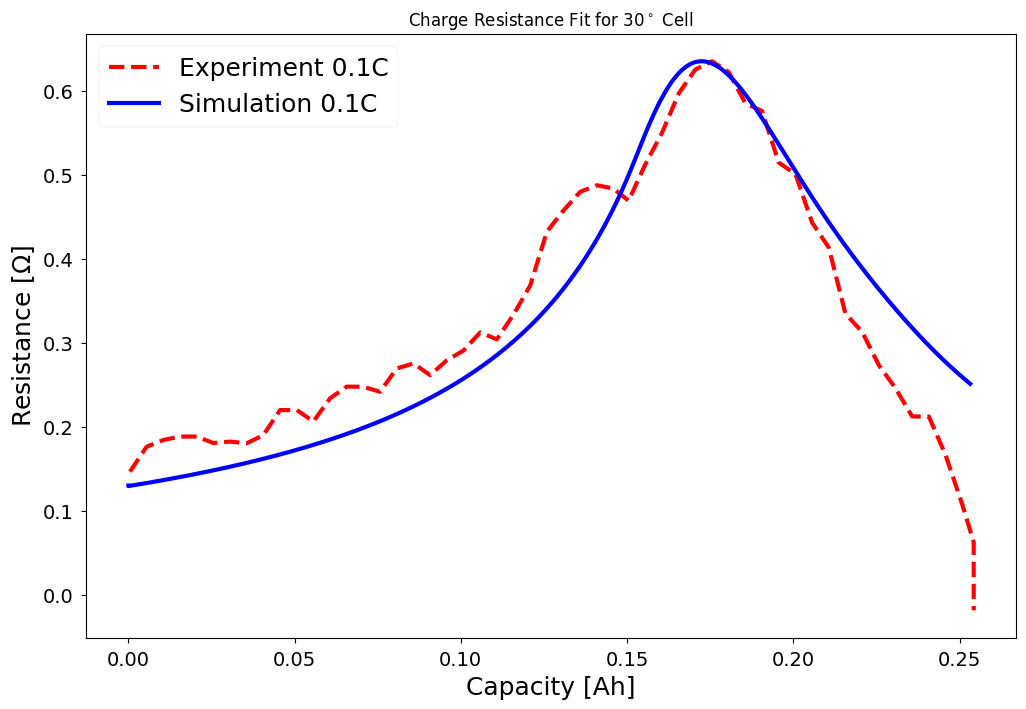

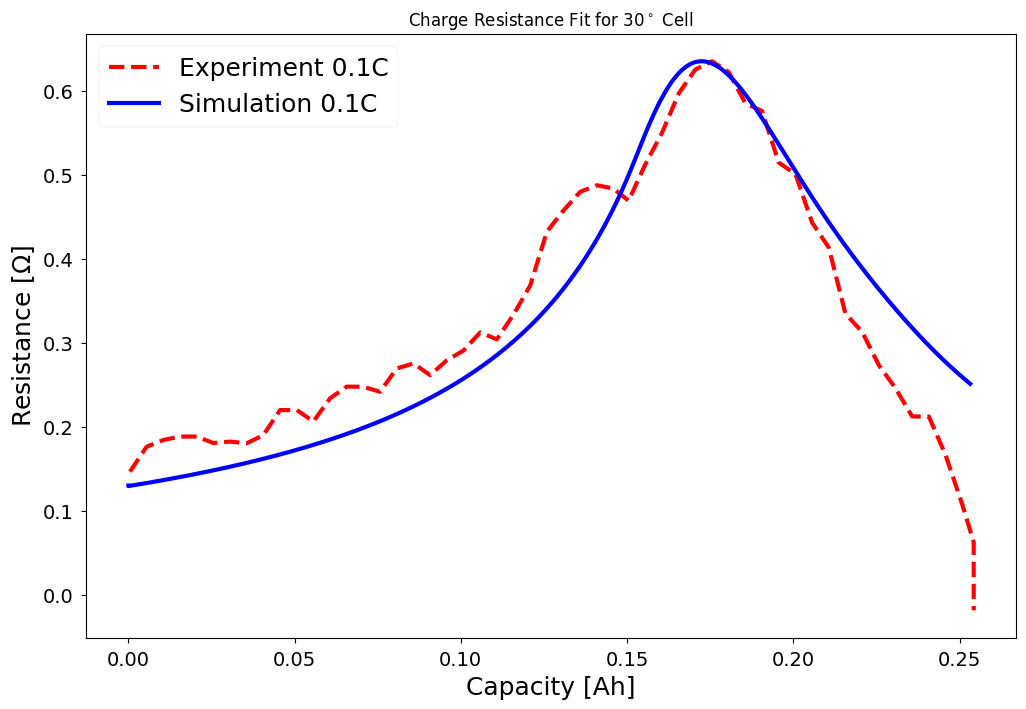

In [6]:
capacity_30 = .0211*sim_30_cha1.solution.t/3600
S4 = sim_30_cha1.solution['S4 [g]'].entries
S2 = sim_30_cha1.solution['S2 [g]'].entries
S1 = sim_30_cha1.solution['S [g]'].entries
Li_30 = S1 + 0.5*S2 + 0.25*S4 

filename = 'Cornish & Marinescu (2021)/res_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']
plt.plot(res_charge_data['30'][0],res_charge_data['30'][1],linestyle='--')

gamma_30 = 1.25
beta_30 = max(Li_30)*gamma_30
alpha_30 = (gamma_30-1)*max(res_charge_data['30'][1])*max(Li_30)
R_30 = alpha_30/(beta_30 - Li_30)

print(alpha_30)
print(beta_30)

plt.plot(capacity_30,R_30)

plt.title("Charge Resistance Fit for $30^\circ$ Cell")
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [$\Omega$]');

## 1.1.4 Fit The Discharge Voltage Curve

In [7]:
loc = index_30
S1_initial_30_dis1 = sim_30_cha1.solution['S [g]'].entries[loc]
S2_initial_30_dis1 = sim_30_cha1.solution['S2 [g]'].entries[loc]
S4_initial_30_dis1 = sim_30_cha1.solution['S4 [g]'].entries[loc]
S8_initial_30_dis1 = sim_30_cha1.solution['S8 [g]'].entries[loc]
Sp_initial_30_dis1 = sim_30_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_30_dis1 = sim_30_cha1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_30_dis1)
print(S4_initial_30_dis1)
print(S2_initial_30_dis1)
print(S1_initial_30_dis1)
print(Sp_initial_30_dis1)
print(V_initial_30_dis1)

0.0006987277172672221
0.15073806137527931
0.2828306309436993
9.071317639008337e-10
0.008220545433794838
2.405203119936759
0.0006987277172672221
0.15073806137527931
0.2828306309436993
9.071317639008337e-10
0.008220545433794838
2.405203119936759


In [8]:
model_30_dis1 = models.Cornish2021()

param_30_dis1 = model_30_dis1.default_parameter_values

# dissolution rate
kp_30 = 1
param_30_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_30_dis1,
        "Initial Condition for S8 ion [g]" : S8_initial_30_dis1,
        "Initial Condition for S4 ion [g]" : S4_initial_30_dis1,
        "Initial Condition for S2 ion [g]" : S2_initial_30_dis1,
        "Initial Condition for S ion [g]" : S1_initial_30_dis1,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_30_dis1,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_30,
        'Precipitation rate [s-1]': kp_30,
        'Reference Temperature [K]': T_30
        }
)


sim_30_dis1 = pybamm.Simulation(
    model_30_dis1,
    parameter_values = param_30_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        #extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

sim_30_dis1 = run_simulation(sim_30_dis1, time_in_seconds = 18220)


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2722.72 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2722.72 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 18218.9 and h

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 18218.9 and h

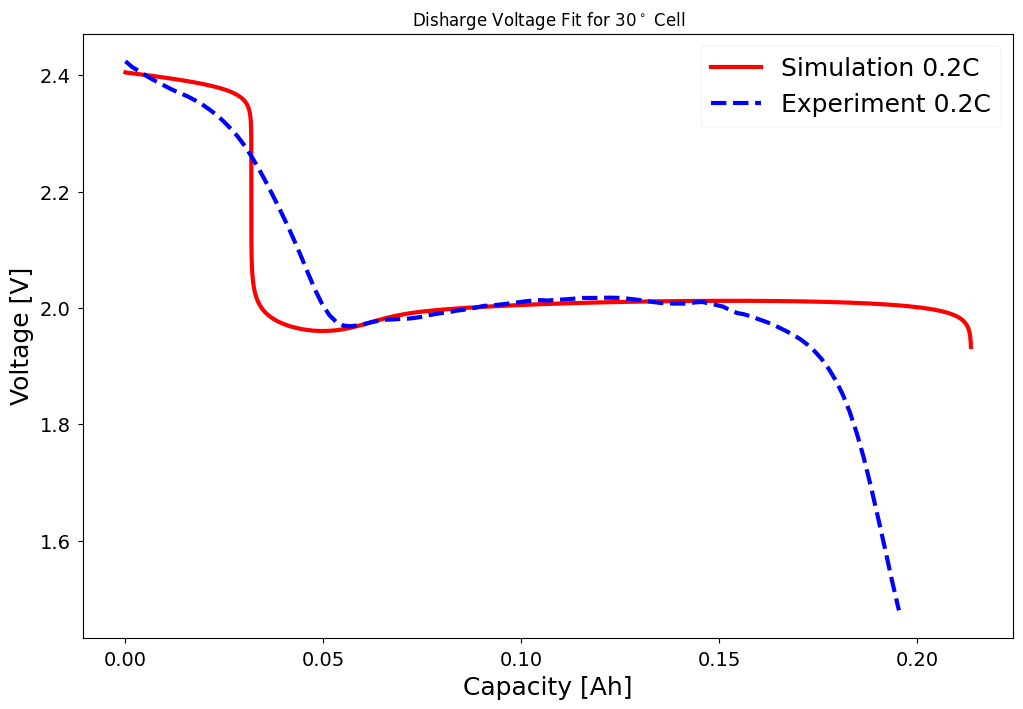

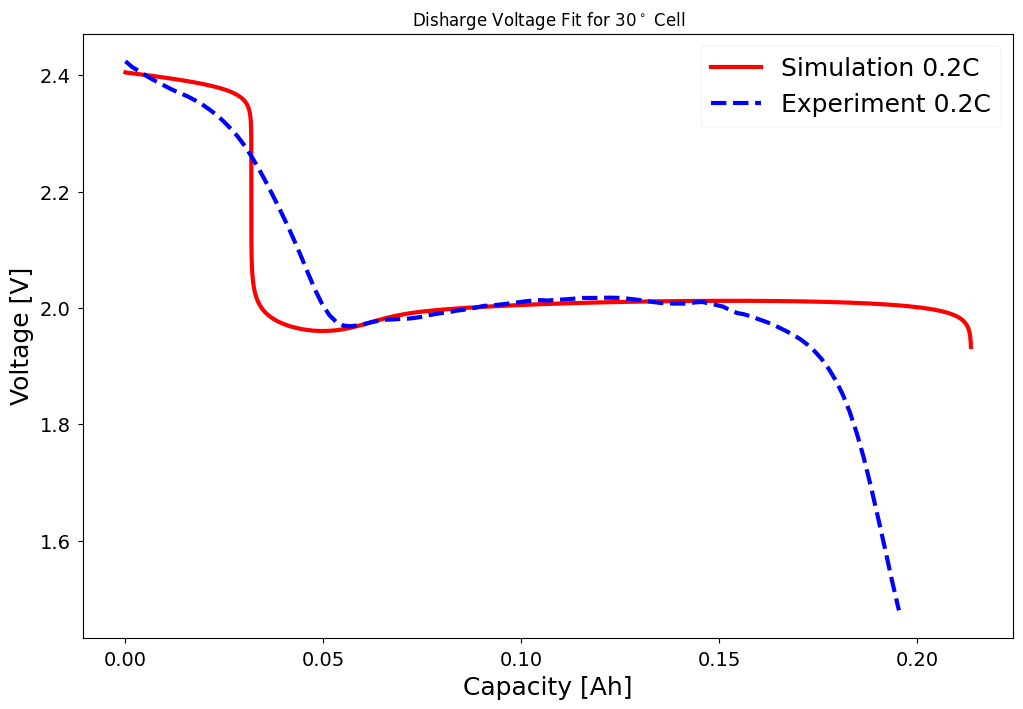

In [9]:
plt.plot(sim_30_dis1.solution.t*0.0422/3600, sim_30_dis1.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'], linestyle='--')

plt.title("Disharge Voltage Fit for $30^\circ$ Cell")
plt.legend(["Simulation 0.2C","Experiment 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

# 1.2 The 40 degree Cell

In [10]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T_40 = 303.15 + 10
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.2C rate
I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# Exchange current constants
ih0 = 5
im0 = 5
il0 = 5

# Saturation mass constant
S_star_40 = S_star_30#2.5e-6

# dissolution rate
kd_40 = kd_30#5000# 4400

# shuttle rate
ks_40 = 1e-3

# Initial value of S1 anion at start of charge
S1_initial_cha_40 = S1_initial_cha_30*10#/50# 5e-4

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T_40))*(V_initial_cha - (2*R*T_40/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T_40))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T_40))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha_40 = S2_func(S1_initial_cha_40)

# Initial charge value of S2
S4_initial_cha_40 = S4_func(S2_initial_cha_40)

# Initial charge value of S2
S8_initial_cha_40 = S8_func(S4_initial_cha_40)

# Initial value of Precipitated sulfur at start of charge
# mass conservation across cells
Sp_initial_cha_40 = (S8_initial_cha_30 + 
                     S4_initial_cha_30 + 
                     S2_initial_cha_30 + 
                     S1_initial_cha_30 + 
                     Sp_initial_cha_30) - (S8_initial_cha_40 +
                                          S4_initial_cha_40 + 
                                          S2_initial_cha_40 + 
                                          S1_initial_cha_40)

# Initial high plateau potential 
EH_40 = EH0 + (R*T_40)*np.log(f_h*(S8_initial_cha_40**(1/4))/(S4_initial_cha_40**(1/2)))/(F)

# Initial high plateau over-potential
eta_H_40 = V_initial_cha - EH_40

# Initial high plateau current
iH_40 = -2*ih0*ar*np.sinh(F*eta_H_40/(2*R*T_40))

# Initial middle plateau potential
EM_40 = EM0 + (R*T_40)*np.log(f_m*(S4_initial_cha_40**(1/2))/S2_initial_cha_40)/(F)

# Initial middle plateau over-potentia
eta_M_40 = V_initial_cha - EM_40

# Initial middle plateau current
iM_40 = -2*im0*ar*np.sinh(F*eta_M_40/(2*R*T_40))

# Initial low plateau potential
EL_40 = EL0 + (R*T_40/F)*np.log(f_l*(S2_initial_cha_40**(1/2))/S1_initial_cha_40)

# Initial low plateau over-potentia
eta_L_40 = V_initial_cha - EL_40

# Initial low plateau current
iL_40 = -2*il0*ar*np.sinh(F*eta_L_40/(2*R*T_40))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha_40))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha_40))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha_40))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha_40))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha_40))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH_40))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H_40))
print('The initial charge value of the high plateau current is {} A'.format(iH_40))
print('The initial charge value of the middle plateau potential is {} V'.format(EM_40))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M_40))
print('The initial charge value of the middle plateau current is {} A'.format(iM_40))
print('The initial charge value of the low plateau potential is {} V'.format(EL_40))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L_40))
print('The initial charge value of the low plateau current is {} A'.format(iL_40))

The initial charge value of precipitated sulfur is -0.46713649789599576 g
The initial charge value of S1 anion is 0.01 g
The initial charge value of S2 anion is 0.8996244642730402 g
The initial charge value of S4 anion is 1.4078624223566333e-13 g
The initial charge value of S8 anion is 5.642336333747543e-54 g
The initial charge value of voltage is 2.0 V
The initial charge value of the high plateau potential is 2.0 V
The initial charge value of the high plateau over-potential is 0.0 V
The initial charge value of the high plateau current is -0.0 A
The initial charge value of the middle plateau potential is 2.0 V
The initial charge value of the middle plateau over-potential is 0.0 V
The initial charge value of the middle plateau current is -0.0 A
The initial charge value of the low plateau potential is 1.9998813829509319 V
The initial charge value of the low plateau over-potential is 0.00011861704906812598 V
The initial charge value of the low plateau current is -0.021099999999991376 A
Th

In [ ]:
# Instantiate the model
model_40 = models.Cornish2021()

# Obtain model parameter dictionary
param_40 = model_40.default_parameter_values

# Update the parameters for charge
param_40.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha_40,
        "Initial Condition for S4 ion [g]" : S4_initial_cha_40,
        "Initial Condition for S2 ion [g]" : S2_initial_cha_40,
        "Initial Condition for S ion [g]" : S1_initial_cha_40,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha_40,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_40,
        'Shuttle rate coefficient during charge [s-1]': ks_40,
        'Dissolution rate [s-1]': kd_40,
        'Reference Temperature [K]': T_40
        }
)

# Instantiate simulation object 
sim_40_cha1 = pybamm.Simulation(
    model_40,
    parameter_values = param_40,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# Run simulation
sim_40_cha1 = run_simulation(sim_40_cha1)


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.0272243 and

psetup failed: psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t 

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian faile

.../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed

The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calc

The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calc

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.0382969 and

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
.../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.0383375 and h = 2.69466e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.0383375 and h = 2.69466e-18, the corrector convergence failed repeatedly or with |h| = hmin.


In [ ]:
# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

index_40 = len(sim_40_cha1.solution.t[sim_40_cha1.solution.t*0.0211/3600 < charge_data['40']['capacity'][-1] ])

capacity = abs(I)*sim_40_cha1.solution.t[:index_40]/3600
voltage = sim_40_cha1.solution['Terminal voltage [V]'].entries[:index_40]

plt.plot(charge_data['40']['capacity'],charge_data['40']['internal voltage'], linestyle='--')

plt.title("Charge Voltage Fit for $40^\circ$ Cell")
plt.plot(capacity, voltage)
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

In [ ]:
capacity_40 = .0211*sim_40_cha1.solution.t/3600
S4 = sim_40_cha1.solution['S4 [g]'].entries
S2 = sim_40_cha1.solution['S2 [g]'].entries
S1 = sim_40_cha1.solution['S [g]'].entries
Li_40 = S1 + 0.5*S2 + 0.25*S4 

filename = 'Cornish & Marinescu (2021)/res_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']
quick_index = len(res_charge_data['40'][0][res_charge_data['40'][0]< .25])
plt.plot(res_charge_data['40'][0][:quick_index],res_charge_data['40'][1][:quick_index],linestyle='--')

max_Li_40 = max(Li_40)
max_R_40 = max(res_charge_data['40'][1])
gamma_40 = 1.2
alpha1_40 = (gamma_40-1)*max_Li_40*max_R_40
beta1_40 = gamma_40*max_Li_40
R_40 = alpha1_40/(beta1_40 - Li_40)

print(alpha1_40)
print(beta1_40)

plt.plot(capacity_40,R_40)

plt.title("Charge Resistance Fit for $40^\circ$ Cell")
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [$\Omega$]');

In [ ]:
loc = index_40
S1_initial_40 = sim_40_cha1.solution['S [g]'].entries[loc]
S2_initial_40 = sim_40_cha1.solution['S2 [g]'].entries[loc]
S4_initial_40 = sim_40_cha1.solution['S4 [g]'].entries[loc]
S8_initial_40 = sim_40_cha1.solution['S8 [g]'].entries[loc]
Sp_initial_40 = sim_40_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_40 = sim_40_cha1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_40)
print(S4_initial_40)
print(S2_initial_40)
print(S1_initial_40)
print(Sp_initial_40)
print(V_initial_40)

In [ ]:
model_40_dis1 = models.Cornish2021()

# precipitation rate
kp_40 = 3

param_40_dis1 = model_40_dis1.default_parameter_values
param_40_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_40,
        "Initial Condition for S8 ion [g]" : S8_initial_40,
        "Initial Condition for S4 ion [g]" : S4_initial_40,
        "Initial Condition for S2 ion [g]" : S2_initial_40,
        "Initial Condition for S ion [g]" : S1_initial_40,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_40,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_40,
        'Precipitation rate [s-1]': kp_40,
        'Reference Temperature [K]': T_40
        }
)


sim_40_dis1 = pybamm.Simulation(
    model_40_dis1,
    parameter_values = param_40_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.01}, 
        max_step_decrease_count = 15,
    ),
)

sim_40_dis1 = run_simulation(sim_40_dis1, time_in_seconds = 19000)


In [ ]:
plt.plot(sim_40_dis1.solution.t*0.0422/3600, sim_40_dis1.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'], linestyle='--')

plt.title("Disharge Voltage Fit for $40^\circ$ Cell")
plt.legend(["Simulation 0.2C","Experiment 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

# 1.3 The 20 degree Cell

In [ ]:
# Experimental cell capacity
cap = 0.211

# Parameters taken from Marinescu et al. (2016)
Ms = 32
F = 9.649e4
R = 8.3145
T_20 = 303.15 - 10
ar = 0.960
nu = 0.0114

f_h = ((4 ** 2) * Ms * nu / 8)**(1/4)
f_m = ((2 ** 2) * Ms * nu / 4)**(1/2)
f_l = ((1 ** 2) * Ms * nu / 2)**(1/2)

# Current at 0.2C rate
I = -cap*0.1

# New standard potentials
EL0 = 1.9
EM0 = 2.41
EH0 = 2.43

# Exchange current constants
ih0 = 5
im0 = 5
il0 = 5

# Saturation mass constant
S_star_20 = 8e-7

# dissolution rate
kd_20 = 6500

# shuttle rate
ks_20 = 0.000001

# Initial value of S1 anion at start of charge
S1_initial_cha_20 = 5e-4

# Initial value of voltage at start of charge
V_initial_cha = 2.0

# Function for which root yields i_L = I
def S2_func(S1):
    constant = np.exp((2*F/(R*T_20))*(V_initial_cha - (2*R*T_20/F)*np.arcsinh(I/(-2*ar*il0)) - EL0 ))/(f_l**2)
    return constant*(S1**2)

# Function from equation (9b) in Cornish & Marinescu (2021)
def S4_func(S2):
    constant = np.exp((2*F/(R*T_20))*(V_initial_cha  - EM0 ))/(f_m**2)
    return constant*(S2**2)

# Function from equation (9a) in Cornish & Marinescu (2021)
def S8_func(S4):
    constant = np.exp((4*F/(R*T_20))*(V_initial_cha - EH0 ))/(f_h**4)
    return constant*(S4**2)

# Initial charge value of S2
S2_initial_cha_20 = S2_func(S1_initial_cha_20)

# Initial charge value of S2
S4_initial_cha_20 = S4_func(S2_initial_cha_20)

# Initial charge value of S2
S8_initial_cha_20 = S8_func(S4_initial_cha_20)

# Initial value of Precipitated sulfur at start of charge
# mass conservation across cells
Sp_initial_cha_20 = (S8_initial_cha_30 + 
                     S4_initial_cha_30 + 
                     S2_initial_cha_30 + 
                     S1_initial_cha_30 + 
                     Sp_initial_cha_30) - (S8_initial_cha_20 +
                                          S4_initial_cha_20 + 
                                          S2_initial_cha_20 + 
                                          S1_initial_cha_20)

# Initial high plateau potential 
EH_20 = EH0 + (R*T_20)*np.log(f_h*(S8_initial_cha_20**(1/4))/(S4_initial_cha_20**(1/2)))/(F)

# Initial high plateau over-potential
eta_H_20 = V_initial_cha - EH_20

# Initial high plateau current
iH_20 = -2*ih0*ar*np.sinh(F*eta_H_20/(2*R*T_20))

# Initial middle plateau potential
EM_20 = EM0 + (R*T_20)*np.log(f_m*(S4_initial_cha_20**(1/2))/S2_initial_cha_20)/(F)

# Initial middle plateau over-potentia
eta_M_20 = V_initial_cha - EM_20

# Initial middle plateau current
iM_20 = -2*im0*ar*np.sinh(F*eta_M_20/(2*R*T_20))

# Initial low plateau potential
EL_20 = EL0 + (R*T_20/F)*np.log(f_l*(S2_initial_cha_20**(1/2))/S1_initial_cha_20)

# Initial low plateau over-potentia
eta_L_20 = V_initial_cha - EL_20

# Initial low plateau current
iL_20 = -2*il0*ar*np.sinh(F*eta_L_20/(2*R*T_20))

print('The initial charge value of precipitated sulfur is {} g'.format(Sp_initial_cha_20))
print('The initial charge value of S1 anion is {} g'.format(S1_initial_cha_20))
print('The initial charge value of S2 anion is {} g'.format(S2_initial_cha_20))
print('The initial charge value of S4 anion is {} g'.format(S4_initial_cha_20))
print('The initial charge value of S8 anion is {} g'.format(S8_initial_cha_20))
print('The initial charge value of voltage is {} V'.format(V_initial_cha))
print('The initial charge value of the high plateau potential is {} V'.format(EH_20))
print('The initial charge value of the high plateau over-potential is {} V'.format(eta_H_20))
print('The initial charge value of the high plateau current is {} A'.format(iH_20))
print('The initial charge value of the middle plateau potential is {} V'.format(EM_20))
print('The initial charge value of the middle plateau over-potential is {} V'.format(eta_M_20))
print('The initial charge value of the middle plateau current is {} A'.format(iM_20))
print('The initial charge value of the low plateau potential is {} V'.format(EL_20))
print('The initial charge value of the low plateau over-potential is {} V'.format(eta_L_20))
print('The initial charge value of the low plateau current is {} A'.format(iL_20))



In [ ]:
# Instantiate the model
model_20 = models.Cornish2021()

# Obtain model parameter dictionary
param_20 = model_20.default_parameter_values

# Update the parameters for charge
param_20.update(
    {
        "Current function [A]": I,
        "Initial Condition for Terminal Voltage [V]": V_initial_cha,
        "Initial Condition for S8 ion [g]" : S8_initial_cha_20,
        "Initial Condition for S4 ion [g]" : S4_initial_cha_20,
        "Initial Condition for S2 ion [g]" : S2_initial_cha_20,
        "Initial Condition for S ion [g]" : S1_initial_cha_20,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_cha_20,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_20,
        'Shuttle rate coefficient during charge [s-1]': ks_20,
        'Dissolution rate [s-1]': kd_20,
        'Reference Temperature [K]': T_20
        }
)

# Instantiate simulation object 
sim_20_cha1 = pybamm.Simulation(
    model_20,
    parameter_values = param_20,
    solver=pybamm.CasadiSolver(
        atol=1e-6,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
    ),
)

# run simulation
sim_20_cha1 = run_simulation(sim_20_cha1)



In [ ]:
# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['20']['capacity'],charge_data['20']['internal voltage'], linestyle='--')

index_20 = len(sim_20_cha1.solution.t[sim_20_cha1.solution.t*0.0211/3600 < charge_data['20']['capacity'][-1]])

capacity = abs(I)*sim_20_cha1.solution.t[:index_20]/3600
voltage = sim_20_cha1.solution['Terminal voltage [V]'].entries[:index_20]


plt.title("Charge Voltage Fit for $20^\circ$ Cell")
plt.plot(capacity, voltage)
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'], loc = 'lower right', frameon=False)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

In [ ]:
capacity_20 = .0211*sim_20_cha1.solution.t/3600
S4 = sim_20_cha1.solution['S4 [g]'].entries
S2 = sim_20_cha1.solution['S2 [g]'].entries
S1 = sim_20_cha1.solution['S [g]'].entries
Li_20 = S1 + 0.5*S2 + 0.25*S4 

filename = 'Cornish & Marinescu (2021)/res_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']
quick_index = len(res_charge_data['20'][0][res_charge_data['20'][0]< .25])
plt.plot(res_charge_data['20'][0][:quick_index],res_charge_data['20'][1][:quick_index],linestyle='--')

max_Li_20 = max(Li_20)
max_R_20 = max(res_charge_data['20'][1])
gamma_20 = 1.5
alpha1_20 = (gamma_20-1)*max_Li_20*max_R_20
beta1_20 = gamma_20*max_Li_20
R_20 = alpha1_20/(beta1_20 - Li_20)

print(alpha1_20)
print(beta1_20)

plt.plot(capacity_20,R_20)

plt.title("Charge Resistance Fit for $20^\circ$ Cell")
plt.legend(['Experiment 0.1C', 'Simulation 0.1C'])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [$\Omega$]');

In [ ]:
loc = index_20
S1_initial_20 = sim_20_cha1.solution['S [g]'].entries[loc]
S2_initial_20 = sim_20_cha1.solution['S2 [g]'].entries[loc]
S4_initial_20 = sim_20_cha1.solution['S4 [g]'].entries[loc]
S8_initial_20 = sim_20_cha1.solution['S8 [g]'].entries[loc]
Sp_initial_20 = sim_20_cha1.solution['Precipitated Sulfur [g]'].entries[loc]
V_initial_20 = sim_20_cha1.solution['Terminal voltage [V]'].entries[loc]
print(S8_initial_20)
print(S4_initial_20)
print(S2_initial_20)
print(S1_initial_20)
print(Sp_initial_20)
print(V_initial_20)

In [ ]:
model_20_dis1 = models.Cornish2021()

# Precipitation rate
kp_20

param_20_dis1 = model_20_dis1.default_parameter_values
param_20_dis1.update(
    {
        "Current function [A]": 2*.0211,
        "Initial Condition for Terminal Voltage [V]": V_initial_20,
        "Initial Condition for S8 ion [g]" : S8_initial_20,
        "Initial Condition for S4 ion [g]" : S4_initial_20,
        "Initial Condition for S2 ion [g]" : S2_initial_20,
        "Initial Condition for S ion [g]" : S1_initial_20,
        "Initial Condition for Precipitated Sulfur [g]" : Sp_initial_20,
        "Lower voltage cut-off [V]" : 1.2,
        "Upper voltage cut-off [V]" : 2.5,
        "Standard Potential L [V]" : EL0,
        "Standard Potential M [V]" : EM0,
        "Standard Potential H [V]" : EH0,
        "Exchange current density L [A.m-2]": il0,
        "Exchange current density M [A.m-2]": im0,
        "Exchange current density H [A.m-2]": ih0,
        "Active reaction area per cell [m2]":ar,
        "S saturation mass [g]": S_star_20,
        'Precipitation rate [s-1]': kp_20,
        'Reference Temperature [K]': T_20
        }
)


sim_20_dis1 = pybamm.Simulation(
    model_20_dis1,
    parameter_values = param_20_dis1,
    solver=pybamm.CasadiSolver(
        atol=1e-8,
        rtol=1e-6,
        dt_max = .01,
        extra_options_setup={"max_step_size": 0.01}, 
        max_step_decrease_count = 15,
    ),
)

sim_20_dis1 = run_simulation(sim_20_dis1, time_in_seconds = 15920)#18130)



In [ ]:
plt.plot(sim_20_dis1.solution.t*0.0422/3600, sim_20_dis1.solution['Terminal voltage [V]'].entries)

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['20']['capacity'],discharge_data['20']['internal voltage'], linestyle='--')

plt.title("Disharge Voltage Fit for $20^\circ$ Cell")
plt.legend(["sim 0.2C","exp 0.2C" ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

# 2.0 All Fitted Results

In [ ]:
index_20 = len(sim_20_cha1.solution.t[sim_20_cha1.solution.t < 36001])
capacity = abs(I)*sim_20_cha1.solution.t[:index_20]/3600
voltage = sim_20_cha1.solution['Terminal voltage [V]'].entries[:index_20]
plt.plot(capacity, voltage, color = 'blue')

index_30 = len(sim_30_cha1.solution.t[sim_30_cha1.solution.t < 36001])
capacity = abs(I)*sim_30_cha1.solution.t[:index_30]/3600
voltage = sim_30_cha1.solution['Terminal voltage [V]'].entries[:index_30]
plt.plot(capacity, voltage, color = 'green')

index_40 = len(sim_40_cha1.solution.t[sim_40_cha1.solution.t < 36001])
capacity = abs(I)*sim_40_cha1.solution.t[:index_40]/3600
voltage = sim_40_cha1.solution['Terminal voltage [V]'].entries[:index_40]
plt.plot(capacity, voltage, color = 'red')

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(charge_data['20']['capacity'],charge_data['20']['internal voltage'], linestyle='--', color = 'blue')
plt.plot(charge_data['30']['capacity'],charge_data['30']['internal voltage'], linestyle='--', color = 'green')
plt.plot(charge_data['40']['capacity'],charge_data['40']['internal voltage'], linestyle='--', color = 'red')


plt.legend(["Simulation $20^\circ$C",
            "Simulation $30^\circ$C",
            "Simulation $40^\circ$C",
            "Experiment $20^\circ$C",
            "Experiment $30^\circ$C",
            "Experiment $40^\circ$C",
            ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')

In [ ]:
plt.plot(capacity_20,R_20, color = 'blue')
plt.plot(capacity_30,R_30, color = 'green')
plt.plot(capacity_40,R_40, color = 'red')

filename = 'Cornish & Marinescu (2021)/res_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

quick_index = len(res_charge_data['20'][0][res_charge_data['20'][0]< .25])
plt.plot(res_charge_data['20'][0][:quick_index],res_charge_data['20'][1][:quick_index],linestyle='--', color = 'blue')

quick_index = len(res_charge_data['30'][0][res_charge_data['30'][0]< .25])
plt.plot(res_charge_data['30'][0][:quick_index],res_charge_data['30'][1][:quick_index],linestyle='--', color = 'green')

quick_index = len(res_charge_data['40'][0][res_charge_data['40'][0]< .25])
plt.plot(res_charge_data['40'][0][:quick_index],res_charge_data['40'][1][:quick_index],linestyle='--', color = 'red')

plt.legend(["Simulation $20^\circ$C",
            "Simulation $30^\circ$C",
            "Simulation $40^\circ$C",
            "Experiment $20^\circ$C",
            "Experiment $30^\circ$C",
            "Experiment $40^\circ$C",
            ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Resistance [$\Omega$]');

In [ ]:
plt.plot(sim_20_dis1.solution.t*0.0422/3600, sim_20_dis1.solution['Terminal voltage [V]'].entries, color = 'blue')
plt.plot(sim_30_dis1.solution.t*0.0422/3600, sim_30_dis1.solution['Terminal voltage [V]'].entries, color = 'green')
plt.plot(sim_40_dis1.solution.t*0.0422/3600, sim_40_dis1.solution['Terminal voltage [V]'].entries, color = 'red')

# get experimental data
filename = 'Cornish & Marinescu (2021)/vol_data'
infile = open(filename,'rb')
data_dict = pickle.load(infile)
infile.close()

discharge_data = data_dict['discharge']
charge_data = data_dict['charge']

plt.plot(discharge_data['20']['capacity'],discharge_data['20']['internal voltage'], linestyle='--', color = 'blue')
plt.plot(discharge_data['30']['capacity'],discharge_data['30']['internal voltage'], linestyle='--', color = 'green')
plt.plot(discharge_data['40']['capacity'],discharge_data['40']['internal voltage'], linestyle='--', color = 'red')


plt.legend(["Simulation $20^\circ$C",
            "Simulation $30^\circ$C",
            "Simulation $40^\circ$C",
            "Experiment $20^\circ$C",
            "Experiment $30^\circ$C",
            "Experiment $40^\circ$C",
            ])
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]');

In [ ]:
print(kd_20)
print(kd_30)
print(kd_40)

print(S_star_20)
print(S_star_30)
print(S_star_40)

In [ ]:
capacity_dis_20 = 2*.0211*sim_20_dis1.solution.t/3600
S4 = sim_20_dis1.solution['S4 [g]'].entries
S2 = sim_20_dis1.solution['S2 [g]'].entries
S1 = sim_20_dis1.solution['S [g]'].entries
Li_dis_20 = S1 + 0.5*S2 + 0.25*S4 
R_dis_20 = alpha1_20/(beta1_20 - Li_dis_20)
plt.plot(capacity_dis_20, R_dis_20, color = 'blue')

capacity_dis_30 = 2*.0211*sim_30_dis1.solution.t/3600
S4 = sim_30_dis1.solution['S4 [g]'].entries
S2 = sim_30_dis1.solution['S2 [g]'].entries
S1 = sim_30_dis1.solution['S [g]'].entries
Li_dis_30 = S1 + 0.5*S2 + 0.25*S4 
R_dis_30 = alpha_30/(beta_30 - Li_dis_30)
plt.plot(capacity_dis_30, R_dis_30, color = 'green')

capacity_dis_40 = 2*.0211*sim_40_dis1.solution.t/3600
S4 = sim_40_dis1.solution['S4 [g]'].entries
S2 = sim_40_dis1.solution['S2 [g]'].entries
S1 = sim_40_dis1.solution['S [g]'].entries
Li_dis_40 = S1 + 0.5*S2 + 0.25*S4 
R_dis_40 = alpha1_40/(beta1_40 - Li_dis_40)
plt.plot(capacity_dis_40, R_dis_40, color = 'red')

filename = 'Cornish & Marinescu (2021)/res_data'
infile = open(filename,'rb')
res_data = pickle.load(infile)
infile.close()

res_discharge_data = res_data['discharge']
res_charge_data = res_data['charge']

plt.plot(res_discharge_data['20'][0],res_discharge_data['20'][1],linestyle='--',color = 'blue')
plt.plot(res_discharge_data['30'][0],res_discharge_data['30'][1],linestyle='--', color = 'green')
plt.plot(res_discharge_data['40'][0],res_discharge_data['40'][1],linestyle='--', color = 'red')
